In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from dynamical_systems.SIR_models import *
import matplotlib.pyplot as plt

### Solve SIR Non-Identifiable Dynamics

In [2]:
x0 = np.array([900,100,0]) # initial condition
true_theta_dyn = np.array([0.02,0.6,0.15]) # True parameters
t_eval = np.linspace(0,6,61)

sol = solve_SIR_forward(true_theta_dyn, sir_dynamics_identifiable, t_eval, x0)

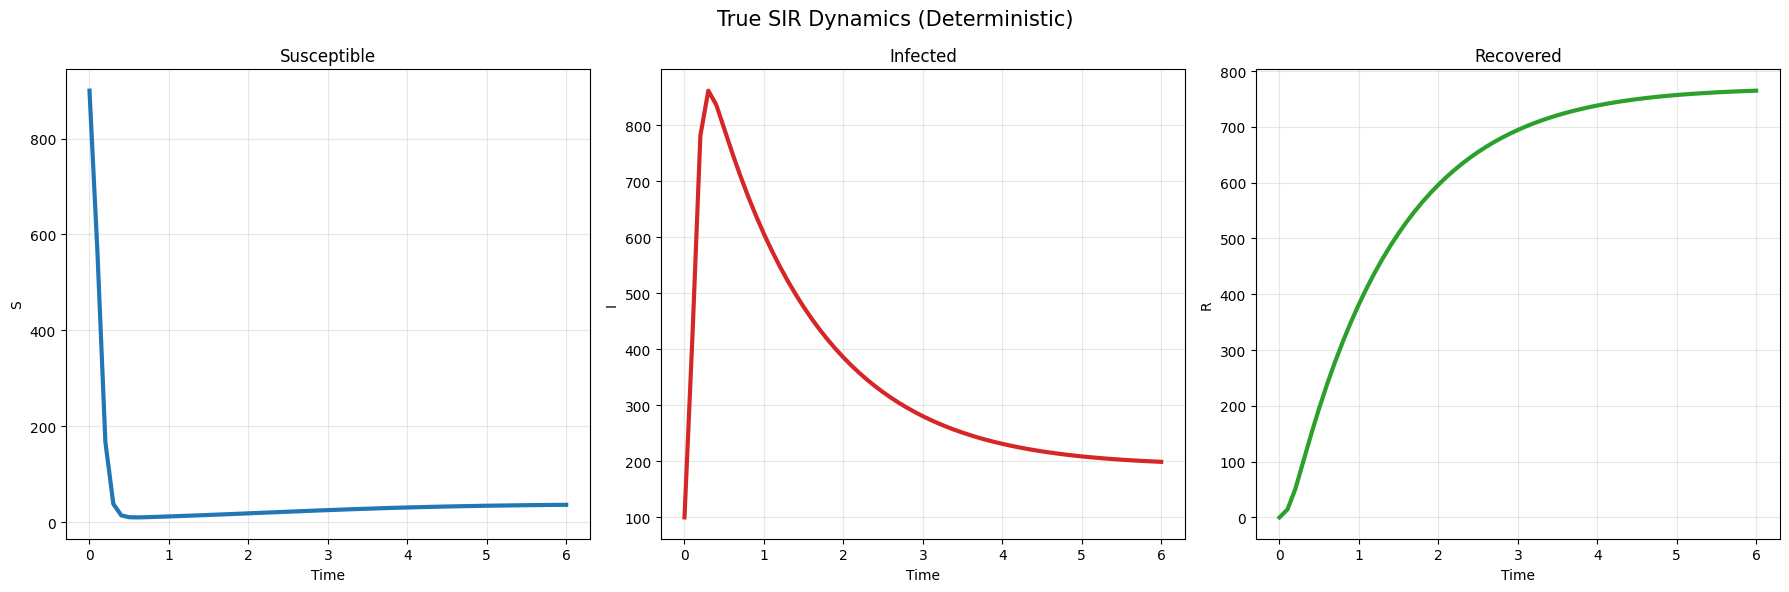

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

states = ['Susceptible', 'Infected', 'Recovered']
colors = ['tab:blue', 'tab:red', 'tab:green']
ylabels = ['S', 'I', 'R']

for i, ax in enumerate(axs):
    ax.plot(sol.t, sol.y[i], color=colors[i], lw=3)
    ax.set_title(states[i])
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('Time')
    ax.grid(alpha=0.3)

fig.suptitle('True SIR Dynamics (Deterministic)', fontsize=15)
plt.tight_layout()
plt.show()

## Generate Sensor Data

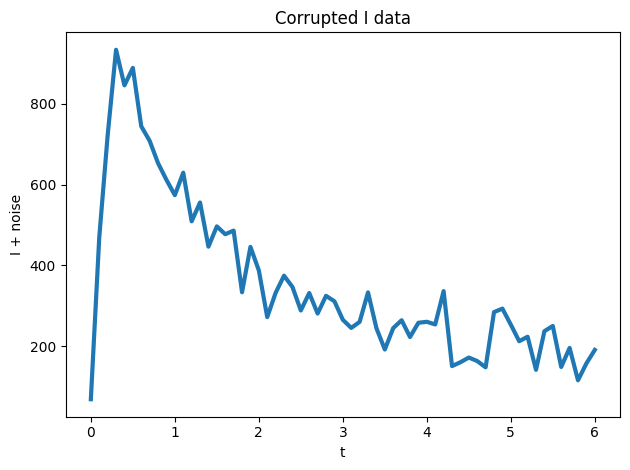

In [13]:
num_points = 61
process_std = 50
whitenoise = process_std*np.random.randn(num_points)
corrupted_I = sol.y[1] + whitenoise

plt.plot(sol.t, corrupted_I, linewidth=3.0)
plt.xlabel('t');plt.ylabel('I + noise')
plt.title("Corrupted I data")
plt.tight_layout()
plt.show()

# Laplace Approximation for SIR Non-Identifiable

In [14]:
prior_mean = np.zeros(4)
prior_cov = np.identity(4)
true_theta_dyn = np.array([0.01,2,0.6,0.15]) # True parameters

logpost = lambda params: log_posterior_SIR(params, 
                                           corrupted_I, 
                                           process_std,
                                           t_eval, 
                                           sir_dynamics_nonIdentifiable, 
                                           prior_mean, 
                                           prior_cov)

guess = np.array([0,0,0,0]) # random guesss
# guess = np.random.randn((3)) # random guess
map_point, cov_laplace = laplace_approx(guess, logpost)
print("map Point = ", map_point)
print("Laplace Covariance = \n" , cov_laplace)

map Point =  [0.14132675 0.14132641 0.59613868 0.14306245]
Laplace Covariance = 
 [[ 7.23951598e-03 -6.97244685e-03 -2.73339782e-04 -1.49971381e-04]
 [-6.97244685e-03  6.90259900e-03  4.73601017e-05  3.36303035e-05]
 [-2.73339782e-04  4.73601017e-05  9.26370762e-04  4.97800631e-04]
 [-1.49971381e-04  3.36303035e-05  4.97800631e-04  3.54500642e-04]]


## Apply DRAM for SIR Non-Identifiable Model

In [15]:
from mcmc.algorithms.dram import *
from mcmc.utils.mcmc_utils import *
from mcmc.diagnostics.autocorrelation import *
from mcmc.utils.run_helpers import *
from mcmc.diagnostics.iac_and_ess import *

In [16]:
target_logpdf = lambda x : log_posterior_SIR(x,
                                             corrupted_I,
                                             process_std,
                                             t_eval,
                                             sir_dynamics_nonIdentifiable,
                                             prior_mean,
                                             prior_cov)

# initial conditions
initial_sample = map_point
initial_cov = cov_laplace # from Laplace Approximation
num_samples = 50000

# Proposal Distribution properties
proposal_logpdf = proposal_mvn_logpdf_eval
proposal_sampler = proposal_mvn_sampler

## Deyaled Rejection
dram_samples = dram_mcmc(initial_sample, initial_cov, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, k0=2000, freq_of_update=500, verbose=True)

samples = dram_samples.samples
print("Accepted Samples Ratio:", dram_samples.accept_rate)

Finished sample 1000, acceptance ratio = 0.472
Finished sample 2000, acceptance ratio = 0.468
Finished sample 3000, acceptance ratio = 0.442
Finished sample 4000, acceptance ratio = 0.399
Finished sample 5000, acceptance ratio = 0.338
Finished sample 6000, acceptance ratio = 0.286
Finished sample 7000, acceptance ratio = 0.255
Finished sample 8000, acceptance ratio = 0.232
Finished sample 9000, acceptance ratio = 0.210
Finished sample 10000, acceptance ratio = 0.193
Finished sample 11000, acceptance ratio = 0.179
Finished sample 12000, acceptance ratio = 0.168
Finished sample 13000, acceptance ratio = 0.158
Finished sample 14000, acceptance ratio = 0.149
Finished sample 15000, acceptance ratio = 0.141
Finished sample 16000, acceptance ratio = 0.135
Finished sample 17000, acceptance ratio = 0.129
Finished sample 18000, acceptance ratio = 0.123
Finished sample 19000, acceptance ratio = 0.118
Finished sample 20000, acceptance ratio = 0.114
Finished sample 21000, acceptance ratio = 0.109
F

In [17]:
new_mh_result= mcmc_burnin_and_thin(dram_samples, burnin_frac=0.2, thin_frac=1)
samples = new_mh_result.samples
print("Accepted Samples Ratio:", new_mh_result.accept_rate)

Accepted Samples Ratio: 0.029775


In [18]:
print(np.sum(samples, axis=0)/samples.shape[0])

[-0.02573283  0.05536203  0.60634268  0.1496533 ]


In [19]:
print(samples.shape)

(40000, 4)


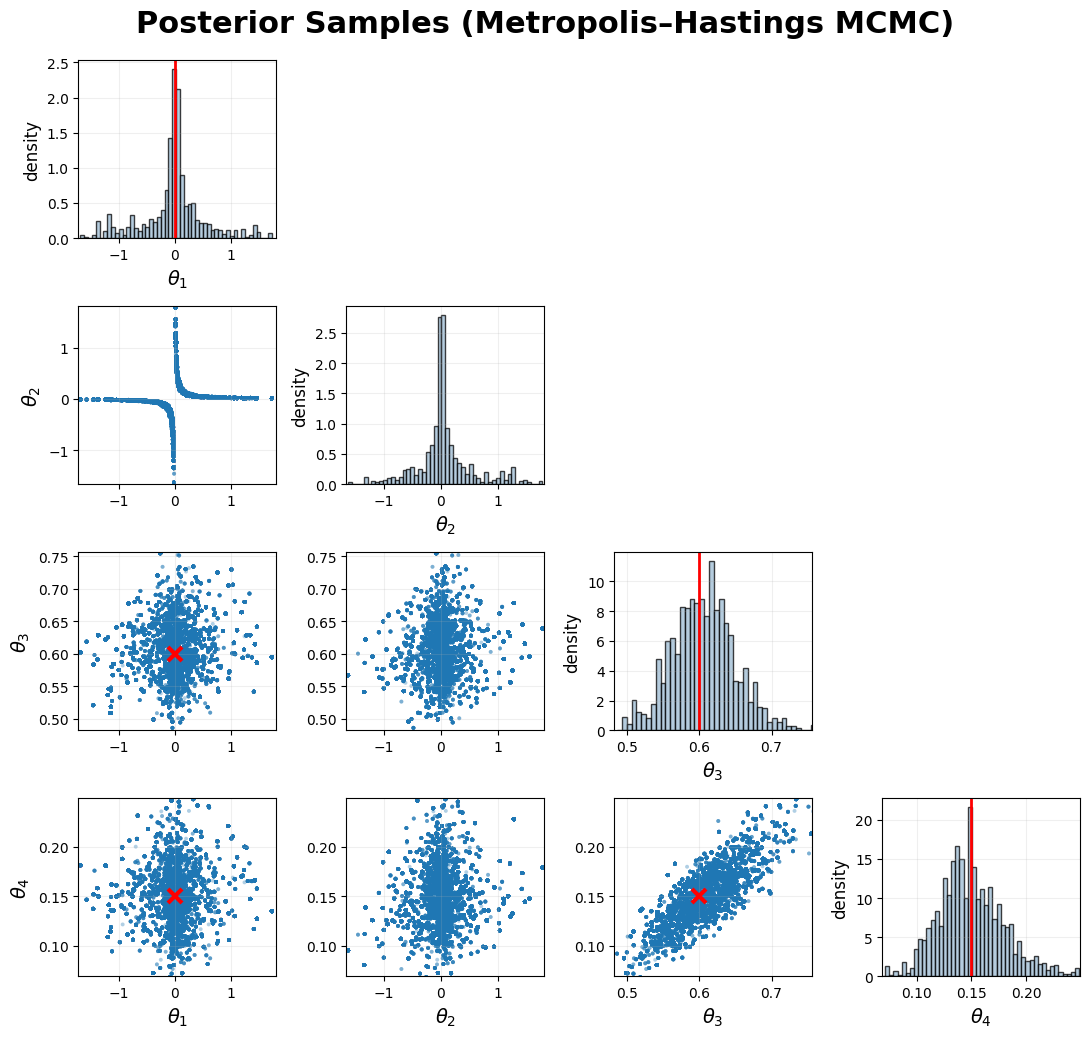

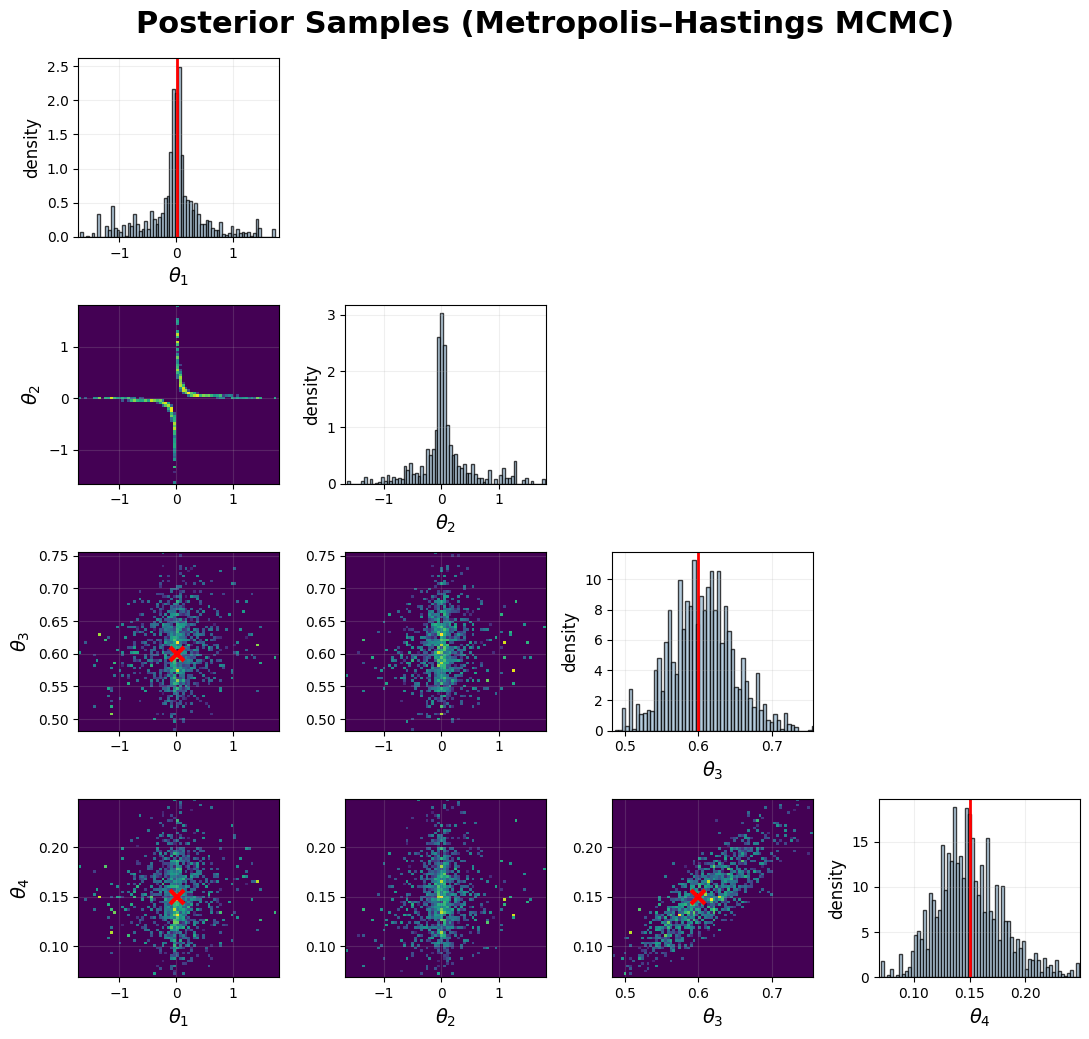

In [ ]:
plt.close()
fig, axs, gs = scatter_matrix_clean(
    11,
    [samples],
    truths=true_theta_dyn,          # or None
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$", r"$\theta_4$"],
    hist_plot=False,
    suptitle="Posterior Samples (DRAM-MCMC)"
)
plt.show()

plt.close(12)
fig, axs, gs = scatter_matrix_clean(
    12,
    [samples],
    truths=true_theta_dyn,
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$", r"$\theta_4$"],
    hist_plot=True,
    nbins=70,
    suptitle="Posterior Samples (DRAM-MCMC)"
)
plt.show()

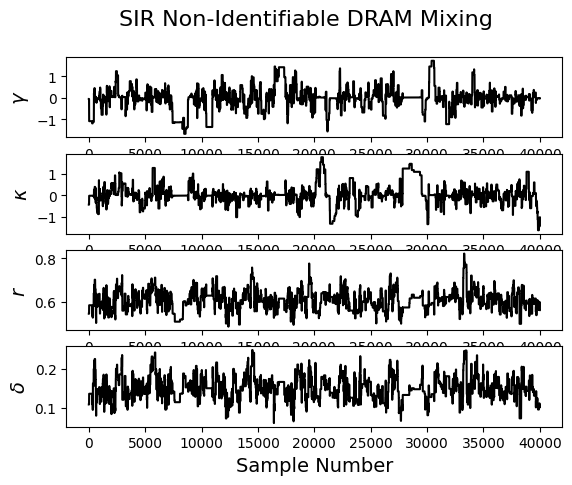

In [21]:
plt.close(4)
fig, axs = plt.subplots(4, 1, num=4)
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$\gamma$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$\kappa$', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$r$', fontsize=14)
axs[3].plot(samples[:, 3], '-k')
axs[3].set_ylabel(r'$\delta$', fontsize=14)
axs[3].set_xlabel('Sample Number', fontsize=14)
fig.suptitle('SIR Non-Identifiable DRAM Mixing', fontsize=16)
# plt.savefig("Images/2b_NonSIR_I_DRAM_Mixing.png")
#axs[1].set_xlim([40000, 50000])
plt.show()